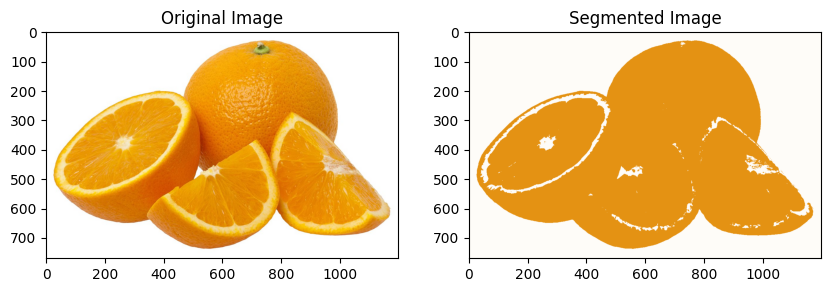

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(image, k, max_iters):
    """
    Perform K-means clustering on an image.

    Parameters:
        image (numpy.ndarray): The input image.
        k (int): The number of clusters.
        max_iters (int): The maximum number of iterations.

    Returns:
        numpy.ndarray: The segmented image.
    """
    # Flatten the image into a 2D array
    pixels = image.reshape(-1, 3)

    # Initialize centroids randomly
    centroids = pixels[np.random.choice(pixels.shape[0], size=k, replace=False)]

    for _ in range(max_iters):
        # Compute distances from pixels to centroids
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)

        # Assign each pixel to the closest centroid
        labels = np.argmin(distances, axis=1)

        # Compute new centroids as the mean of the pixels assigned to each centroid
        new_centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(k)])

        # If centroids didn't change, stop the algorithm
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    # Replace each pixel with its centroid
    segmented_image = centroids[labels].reshape(image.shape).astype(np.uint8)

    return segmented_image

# Load the image
image = plt.imread('orange.jpg')

# Perform K-means clustering
k = 2 # Number of clusters
max_iters = 10  # Maximum number of iterations
segmented_image = kmeans(image, k, max_iters)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image')
plt.show()

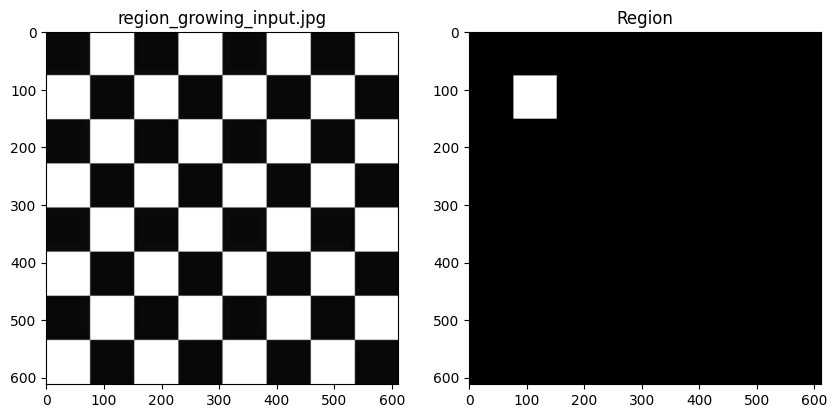

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def region_growing(img, seed):
    # parameters
    height, width = img.shape
    intensity_threshold = 20

    # initialization
    visited = np.zeros_like(img, dtype=bool)
    region = np.zeros_like(img, dtype=bool)
    list_pixels = [seed]

    while len(list_pixels) > 0:
        s = list_pixels.pop()
        x, y = s

        if not visited[x, y]:
            visited[x, y] = True

            # check if pixel intensity is similar to seed pixel
            if np.abs(int(img[x, y]) - int(img[seed])) <= intensity_threshold:
                region[x, y] = True

                # add neighbours to the list
                if x > 0: list_pixels.append((x-1, y))
                if x < height-1: list_pixels.append((x+1, y))
                if y > 0: list_pixels.append((x, y-1))
                if y < width-1: list_pixels.append((x, y+1))

    return region

# Load the image
image = plt.imread('region.jpg')
image = image[:,:,0]  # use one channel of the image

# Perform region growing
seed = (100, 100)  # seed point
region = region_growing(image, seed)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('region_growing_input.jpg')
plt.subplot(1, 2, 2)
plt.imshow(region, cmap='gray')
plt.title('Region')
plt.show()

26


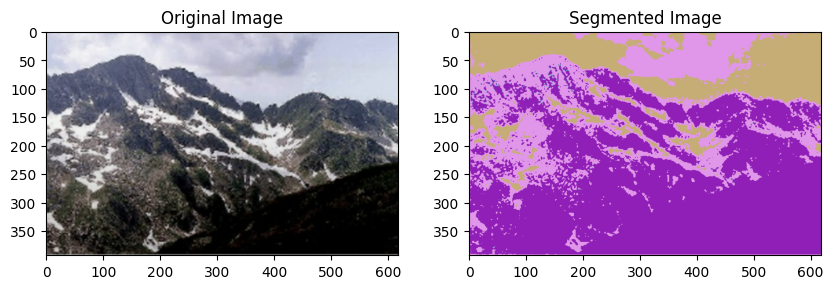

In [1]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import PIL.Image
import cv2

def mean_shift(img, window_size=100, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)):
    img_to_2dArray = img.reshape(-1, 3)
    
    num_points, num_features = img_to_2dArray.shape
    point_considered = np.zeros(num_points, dtype=bool)
    labels = -1 * np.ones(num_points, dtype=int)
    label_count = 0

    tree = KDTree(img_to_2dArray)

    for i in range(num_points):
        if point_considered[i]:
            continue

        Center_point = img_to_2dArray[i]
        while True:
            in_window = tree.query_ball_point(Center_point, r=window_size)
            new_center = np.mean(img_to_2dArray[in_window], axis=0)

            if np.linalg.norm(new_center - Center_point) < criteria[1]:
                labels[in_window] = label_count
                point_considered[in_window] = True
                label_count += 1
                break

            Center_point = new_center

    # Generate a unique color for each label
    unique_colors = np.random.randint(0, 255, (label_count, 3))
    # print(unique_colors)
    # print(labels)
    print(label_count)

    # Create a new image where each pixel is assigned the color of its cluster
    new_img = np.zeros_like(img)
    for i in range(label_count):
        new_img[labels.reshape(img.shape[:2]) == i] = unique_colors[i]

    output_image = np.array(new_img, np.uint8)
    return output_image

# Example usage
image_path = 'agg.jpg'
image = np.asarray(PIL.Image.open(image_path))
segmented_image = mean_shift(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.show()

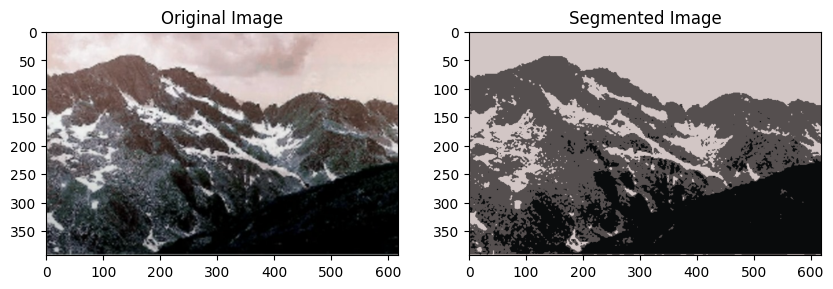

In [2]:
from PyQt5.QtWidgets import QSlider
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
def calculate_distance(x1, x2):
    """
    Calculates Euclidean distance between two points.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))

def clusters_distance(cluster1, cluster2):
    """
    Calculates the distance between two clusters as the maximum distance between any two points in the clusters.
    """
    return max([calculate_distance(point1, point2) for point1 in cluster1 for point2 in cluster2])

def clusters_mean_distance(cluster1, cluster2):
    """
    Calculates the mean distance between two clusters as the Euclidean distance between their centroids.
    """
    cluster1_center = np.average(cluster1, axis=0)
    cluster2_center = np.average(cluster2, axis=0)
    return calculate_distance(cluster1_center, cluster2_center)

def initial_clusters(image_clusters, k):
    """
    Initializes the clusters with k colors by grouping the image pixels based on their color.
    """
    cluster_color = int(256 / k)
    groups = {}
    for i in range(k):
        color = i * cluster_color
        groups[(color, color, color)] = []
    for i, p in enumerate(image_clusters):
        go = min(groups.keys(), key=lambda c: calculate_distance(p, c))
        groups[go].append(p)
    return [group for group in groups.values() if len(group) > 0]

def get_cluster_center(point, cluster, centers):
    """
    Returns the center of the cluster to which the given point belongs.
    """
    point_cluster_num = cluster[tuple(point)]
    center = centers[point_cluster_num]
    return center

def get_clusters(image_clusters, clusters_number):
    """
    Agglomerative clustering algorithm to group the image pixels into a specified number of clusters.
    """
    clusters_list = initial_clusters(image_clusters, clusters_number)
    cluster = {}
    centers = {}

    while len(clusters_list) > clusters_number:
        cluster1, cluster2 = min(
            [(c1, c2) for i, c1 in enumerate(clusters_list) for c2 in clusters_list[:i]],
            key=lambda c: clusters_mean_distance(c[0], c[1]))

        clusters_list = [cluster_itr for cluster_itr in clusters_list if not np.array_equal(cluster_itr, cluster1) and not np.array_equal(cluster_itr, cluster2)]
        merged_cluster = cluster1 + cluster2
        clusters_list.append(merged_cluster)

    for cl_num, cl in enumerate(clusters_list):
        for point in cl:
            cluster[tuple(point)] = cl_num

    for cl_num, cl in enumerate(clusters_list):
        centers[cl_num] = np.average(cl, axis=0)

    return cluster, centers

def apply_agglomerative_clustering(image, clusters_number, initial_clusters_number):
    """
    Applies agglomerative clustering to the image and returns the segmented image.
    """
    flattened_image = np.copy(image.reshape((-1, 3)))
    cluster, centers = get_clusters(flattened_image, clusters_number)
    output_image = []
    for row in image:
        rows = []
        for col in row:
            rows.append(get_cluster_center(col, cluster, centers))
        output_image.append(rows)    
    return np.array(output_image, np.uint8)  # Convert to numpy array after the loop
image = cv.imread('agg.jpg')


segmented_image = apply_agglomerative_clustering(image, clusters_number=3, initial_clusters_number=2000)
# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image')
plt.show()

length of clusters:200
closest_clusters:(137, 138)
K:199
closest_clusters:(18, 19)
K:198
closest_clusters:(14, 15)
K:197
closest_clusters:(144, 145)
K:196
closest_clusters:(4, 5)
K:195
closest_clusters:(129, 130)
K:194
closest_clusters:(109, 110)
K:193
closest_clusters:(29, 30)
K:192
closest_clusters:(26, 27)
K:191
closest_clusters:(170, 171)
K:190
closest_clusters:(13, 14)
K:189
closest_clusters:(61, 62)
K:188
closest_clusters:(83, 84)
K:187
closest_clusters:(57, 58)
K:186
closest_clusters:(69, 70)
K:185
closest_clusters:(146, 147)
K:184
closest_clusters:(84, 85)
K:183
closest_clusters:(172, 173)
K:182
closest_clusters:(82, 83)
K:181
closest_clusters:(117, 118)
K:180
closest_clusters:(108, 109)
K:179
closest_clusters:(89, 90)
K:178
closest_clusters:(63, 64)
K:177
closest_clusters:(139, 140)
K:176
closest_clusters:(95, 96)
K:175
closest_clusters:(38, 39)
K:174
closest_clusters:(126, 127)
K:173
closest_clusters:(38, 39)
K:172
closest_clusters:(56, 57)
K:171
closest_clusters:(131, 132)
K

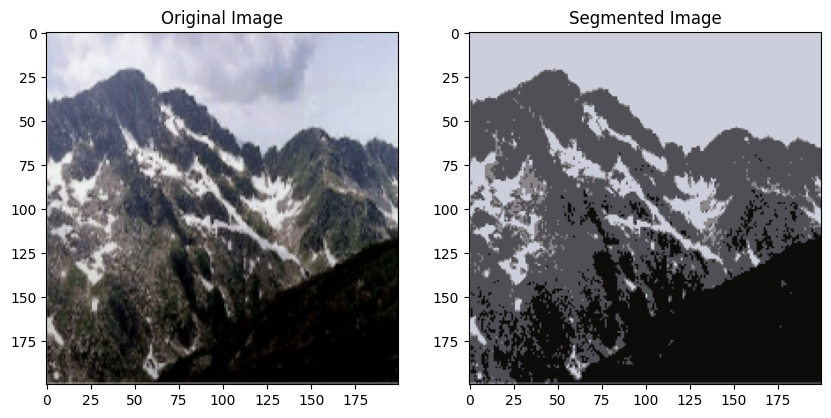

In [19]:


import cv2 as cv
import cv2
import numpy as np
from PyQt5.QtWidgets import QSlider
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

def eculidean_distance(point1,point2):
    return np.sqrt(np.sum((point1-point2)**2))

def extract_features(img):
    new_img = img.reshape((-1,3)) ## 3 features RGB
    new_img = new_img.astype("float32")
    return new_img

def init_clusters(features,nump_int):
    cluster_color = int(256 / nump_int)
    groups = {}
    for i in range(nump_int):
        color = i * cluster_color
        groups[(color, color, color)] = []
        
    for pixel_point in features:
        min_dist = float('inf')
        for key ,group in groups.items():
            dist = eculidean_distance(pixel_point,list(key))
            if dist< min_dist:
                min_dist = dist
                target_cluster = key
        groups[target_cluster].append(pixel_point)  
    print(f"length of clusters:{len(list(groups.keys()))}")    
    return [group for group in groups.values() if len(group) > 0]

def centroid_linkage(cluster1,cluster2):
    mean_cluster1 =np.mean(cluster1,axis=0)
    mean_cluster2 =np.mean(cluster2,axis=0)
    return eculidean_distance(mean_cluster1,mean_cluster2)

def find_the_closest_clusters(clusters_list):
    min_dist = float('inf')
    for cluster1_idx in range(len(clusters_list[:-1])):
        for cluster2_idx in range((cluster1_idx+1),len(clusters_list)):
#             print(f"indices:{(cluster1_idx,cluster2_idx)}")
            dist = centroid_linkage(clusters_list[cluster1_idx],clusters_list[cluster2_idx])
            if dist <  min_dist:
                min_dist = dist
                closest_clusters = (cluster1_idx,cluster2_idx)
    return closest_clusters


def merge_clusters(closest_clusters,clusters_list):
    new_clusters_list = []
    new_clusters_list.append(clusters_list[closest_clusters[0]] + clusters_list[closest_clusters[1]])
    for cluster_id in range(len(clusters_list)):
        if cluster_id == closest_clusters[0] or cluster_id == closest_clusters[1]:
            continue
        new_clusters_list.append(clusters_list[cluster_id])
   
    
    return new_clusters_list

def agglomerative_clustring(image,K): 
    cluster = {}
    centers = {}
    features = extract_features(image)
    clusters_list = init_clusters(features,200) ## 200 initial number of contours
    while K < len(clusters_list):
        closest_clusters = find_the_closest_clusters(clusters_list)
        print(f"closest_clusters:{closest_clusters}")
        clusters_list = merge_clusters(closest_clusters,clusters_list)
        print(f"K:{len(clusters_list) }")
    for cl_num, cl in enumerate(clusters_list):
        for point in cl:
            cluster[tuple(point)] = cl_num
            
    for cl_num, cl in enumerate(clusters_list):
        centers[cl_num] = np.mean(cl, axis=0)
   
    return cluster,centers
def get_cluster_center(point, cluster, centers):
    """
    Returns the center of the cluster to which the given point belongs.
    """
    point_cluster_num = cluster[tuple(point)]
    center = centers[point_cluster_num]
    return center

def get_segmentated_image(image, cluster,centers):
    output_image = []
    for row in image:
        rows = []
        for col in row:
            rows.append(get_cluster_center(list(col), cluster, centers))
        output_image.append(rows)    
    output_image = np.array(output_image, np.uint8)
    return output_image


image = cv.imread('agg.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image = cv2.resize(image, (200, 200))
image_copy = np.copy(image)

cluster,centers = agglomerative_clustring(image_copy,4)

segmentated_image = get_segmentated_image(image,cluster,centers)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(segmentated_image)
plt.title('Segmented Image')
plt.show()